<p style="text-align:center">
PSY 381D <b>Brain Connectivity</b>, Spring 2019


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/JupyterConnectivitySpring2019/blob/master/Images/Banner.png?raw=true" alt="title pics"/>

</p>

<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> fMRI pre-processing </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>April 15, 2019</b></p>

<hr style="height:5px;border:none" />

# 1. Data
<hr style="height:1px;border:none" />

For today's exercise, we use 3 resting-state fMRI data sets (and their derivative files).
* Oxford, `sub16112`
* Queensland, `sub66095`
* NewYork, `sub83453`

All the files generated from these subjects are found in the **`DatafMRIPreprop`** directory.

# 2. fMRI pre-processing steps
<hr style="height:1px;border:none" />

fMRI data pre-processing steps involved in construction of functional connectivity networks are very similar to pre-processing steps for conventional fMRI studies to examine activations. Here is a summary comparing pre-processing steps between activation fMRI studies and fMRI network construction.

<table>
  <tr>
      <th style="text-align: center"><b>Step</b></th>
      <th style="text-align: left"><b>fMRI activation</b></th>
      <th style="text-align: left"><b>fMRI network</b></th>
  </tr>
  <tr>
    <td style="text-align: center">1</td>
    <td style="text-align: left">Motion correction</td> 
    <td style="text-align: left">Motion correction</td>
  </tr>
  <tr>
    <td style="text-align: center">2</td>
    <td style="text-align: left">Co-registration to T1</td> 
    <td style="text-align: left">Co-registration to T1</td>
  </tr>
  <tr>
    <td style="text-align: center">3</td>
    <td style="text-align: left">Normalization to template</td> 
    <td style="text-align: left">Normalization to template</td>
  </tr>
  <tr>
    <td style="text-align: center">4</td>
    <td style="text-align: left; color:blue">Spatial smoothing</td> 
    <td style="text-align: left">Band-pass filtering</td>
  </tr>
  <tr>
    <td style="text-align: center">5</td>
    <td style="text-align: left">Band-pass filtering</td> 
    <td style="text-align: left; color:red">Global signal regression</td>
  </tr>
  <tr>
    <td style="text-align: center">6</td>
    <td style="text-align: left"> </td> 
    <td style="text-align: left; color:red">Motion scrubbing</td>
  </tr>
</table>

<p style="text-align: center; color:blue; margin-top: 30px; font-size: 10px">Blue: steps specific to fMRI activation analysis</p>
<p style="text-align: center; color:red; margin-top: 0px; font-size: 10px">Red: steps specific to fMRI network analysis</p>

Today, we will focus on pre-processing steps that are unique to fMRI network analysis.

# 3. Global signal regression
<hr style="height:1px;border:none" />

In this step, 6 motion parameters (3 parameters for rotations, and 3 parameters for translations) are regressed out from fMRI data. While this is not unique for some fMRI activation studies where subject motion is of concern, regressing out motion parameters is routinely done in fMRI pre-processing for network construction.

In addition, global mean signals (from the brain parenchyma, deep white matter, and CSF) are also regressed out. To see the reason why such **global signal regression** (**GSR**) is necessary, we can take a look at the ROI time series without and with GSR.

`<PlotTimeSeries.py>`

In [1]:
%matplotlib inline

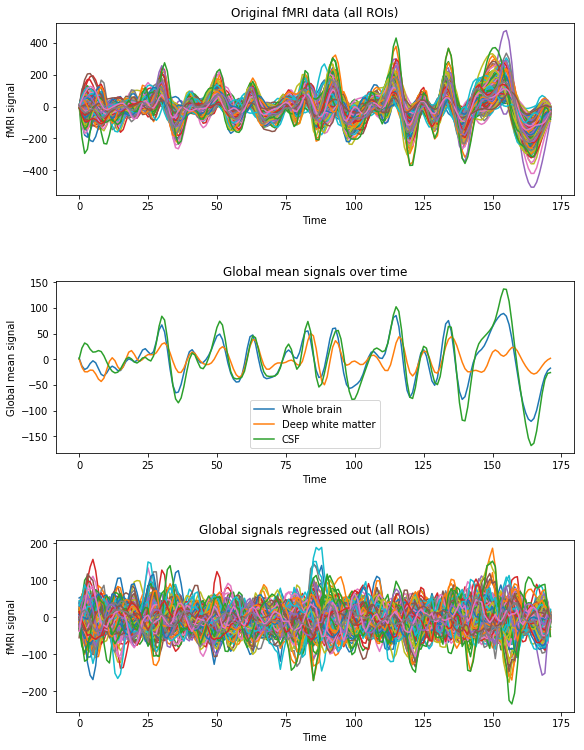

In [5]:
import numpy as np
import matplotlib.pyplot as plt


##### File business
fTS = 'DatafMRIPreprop/Oxford_sub16112_Rt2_K200.npz'
fTS_reg = 'DatafMRIPreprop/Oxford_sub16112_WBWMCSF_Rt2_K200.npz'
fGlobalMean = 'DatafMRIPreprop/Oxford_sub16112_PhysPar.npz'


##### Loading the data
X_TS = np.load(fTS)['ts']
X_GM = np.load(fGlobalMean)['PhysPar']
X_TS_reg = np.load(fTS_reg)['ts']


##### plotting
plt.figure(figsize=[9,11])

plt.subplot(311)
plt.plot(X_TS)
plt.xlabel('Time')
plt.ylabel('fMRI signal')
plt.title('Original fMRI data (all ROIs)')

plt.subplot(312)
plt.plot(X_GM[:,0], label='Whole brain')
plt.plot(X_GM[:,1], label='Deep white matter')
plt.plot(X_GM[:,2], label='CSF')
plt.xlabel('Time')
plt.ylabel('Global mean signal')
plt.title('Global mean signals over time')
plt.legend()

plt.subplot(313)
plt.plot(X_TS_reg)
plt.xlabel('Time')
plt.ylabel('fMRI signal')
plt.title('Global signals regressed out (all ROIs)')

plt.subplots_adjust(left=0.15, right=0.95, bottom=0.08, top=0.95,
                    hspace=0.5)
plt.show()


As you can see, pretty much all ROI time series are correlated with global mean signals. This is because some physiological signals (especially respiration and associated BOLD signal changes) are still present in fMRI data. To lessen the impact of these confounding signals, the global mean signals are regressed out. The resulting time series data are much less confounded by these global signals.

People have different opinions about what global signal should be regressed out (whole brain parenchyma, white matter, and CSF, or some combinations thereof). Some proponents of GSR argue that correcting all these signals removes all underlying confounding signals. Some critics of GSR argue that removing these signals artificially introduces anti-correlations (or negative correlations). Let's examine the distribution of correlation coefficients resulting from fMRI without GSR, with full GSR (whole brain, white matter & CSF), as well as with partial GSR (white matter & CSF; a popular combination).

`<Histogram.py>`

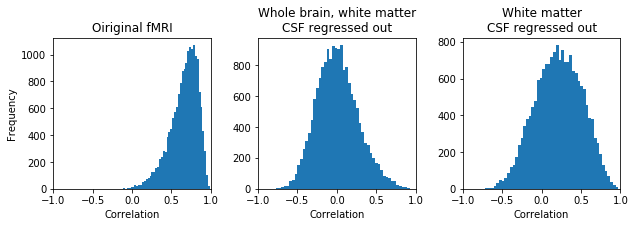

In [7]:
import numpy as np
import matplotlib.pyplot as plt

###### Loading the time series data
fTS = 'DatafMRIPreprop/Oxford_sub16112_Rt2_K200.npz'
fTS_WBWMCSF = 'DatafMRIPreprop/Oxford_sub16112_WBWMCSF_Rt2_K200.npz'
fTS_WMCSF = 'DatafMRIPreprop/Oxford_sub16112_WMCSF_Rt2_K200.npz'
TS = np.load(fTS)['ts']
TS_WBWMCSF = np.load(fTS_WBWMCSF)['ts']
TS_WMCSF = np.load(fTS_WMCSF)['ts']
nNode = TS.shape[-1]


####### Calculating the correlation matrices
R = np.corrcoef(TS, rowvar=False)
R_WBWMCSF = np.corrcoef(TS_WBWMCSF, rowvar=False)
R_WMCSF = np.corrcoef(TS_WMCSF, rowvar=False)

# zeroing the main diagonal
R[np.arange(nNode), np.arange(nNode)] = 0
R_WBWMCSF[np.arange(nNode), np.arange(nNode)] = 0
R_WMCSF[np.arange(nNode), np.arange(nNode)] = 0


###### Histograms of the correlation matrices
nBin = 50
plt.figure(figsize=[9,3])

plt.subplot(131)
plt.hist(R[np.triu_indices(nNode,1)], nBin)
plt.xlim(-1,1)
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Oiriginal fMRI')

plt.subplot(132)
plt.hist(R_WBWMCSF[np.triu_indices(nNode,1)], nBin)
plt.xlim(-1,1)
plt.xlabel('Correlation')
plt.title('Whole brain, white matter\nCSF regressed out')

plt.subplot(133)
plt.hist(R_WMCSF[np.triu_indices(nNode,1)], nBin)
plt.xlim(-1,1)
plt.xlabel('Correlation')
plt.title('White matter\nCSF regressed out')


plt.subplots_adjust(left=0.1, right=0.975, bottom=0.15, top=0.85,
                    wspace=0.3, hspace=0.4)
plt.show()



As you can see, without GSR, correlations are highly skewed to the right, with most correlations being positive. With a full GSR, the distribution of correlations is centered at zero. With a partial GSR (white matter & CSF), the distribution of correlations is still skewed to the right, with the majority of correlations still positive.

What would be the impact of these differences in the distribution of correlations? We can examine the networks resulting from these three approaches. These networks are formed to have the average degree of 20.

`<ModulesGSR.py>`

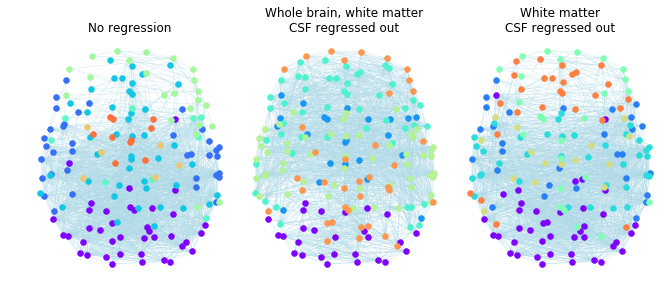

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community   # Louvain method

# ROI IDs
# Left precentral gyrus: 50
# Left post-cingulate, precuneus: 174

##### Custom distinct color function --- to be used later
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


####### Loading the network data
fTS = 'DatafMRIPreprop/Oxford_sub16112_Rt2_K200.npz'
nodes = np.load(fTS)['nodes']
xyz = np.load(fTS)['xyz']
fG = 'DatafMRIPreprop/Oxford_sub16112_Rt2_K200_deg20.adjlist'
fG_WBWMCSF = 'DatafMRIPreprop/Oxford_sub16112_WBWMCSF_Rt2_K200_deg20.adjlist'
fG_WMCSF = 'DatafMRIPreprop/Oxford_sub16112_WMCSF_Rt2_K200_deg20.adjlist'
G = nx.read_adjlist(fG, nodetype=int)
G_WBWMCSF = nx.read_adjlist(fG_WBWMCSF, nodetype=int)
G_WMCSF = nx.read_adjlist(fG_WMCSF, nodetype=int)
G_list = [G, G_WBWMCSF, G_WMCSF]
netLabel = ['No regression',
            'Whole brain, white matter\nCSF regressed out',
            'White matter\nCSF regressed out']


####### Finding the giant component and modular partition
partition_list = []
GC_list = []
for iG in G_list:
    # finding the giant component
    GC_nodes = max(nx.connected_components(iG), key=len)  
    GC = iG.subgraph(GC_nodes)
    GC_list.append(iG)
    ###### modular partition by Louvain
    partition = community.best_partition(GC)
    partition_list.append(partition)



###### drawing the graph
# dictionary of xy-coordinates
pos = {}
for iROI in range(len(nodes)):
    pos[nodes[iROI]] = xyz[iROI,:2]

# Loop over states for visualization
plt.figure(figsize=[9,4])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,3,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    node_color_list = get_cmap(nComm+1,'rainbow')
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        nx.draw_networkx_nodes(iGC, pos, 
                               nodelist=nodeList,
                               node_color = np.array([node_color_list(iComm)]),
                               node_size=30)
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.85)
plt.show()

Without GSR, what you would likely see is a network of blood supplies into the brain. This is because fMRI signals are highly contaminated with physiological noises.

* Comment on full GSR
* Comment on partial GSR

In [ ]:
###### drawing the graph (SM module)
# Identifying SM module for each network
ROI_SM = 50  # ROI=50 --> Left precentral gyrus
indSM_list = []
for iMod in partition_list:
    indSM_list.append(iMod[ROI_SM])
    
# Loop over states for visualization
plt.figure(figsize=[9,4])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,3,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        if iComm==indSM_list[i]:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'orangered',
                                   node_size=30)
        else:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'skyblue',
                                   node_size=15)
            
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.suptitle('Sensory-motor module', size=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.8)
plt.show()





###### drawing the graph (DMN module)
# Identifying DMN module for each network
ROI_DMN = 174  # ROI=174 --> Left posterior cingulate / precuneus
indDMN_list = []
for iMod in partition_list:
    indDMN_list.append(iMod[ROI_DMN])
    
# Loop over states for visualization
plt.figure(figsize=[9,4])
for i,iGC in enumerate(GC_list):
    
    # finally, graph with communities in different colors (Louvain)
    plt.subplot(1,3,i+1)
    nComm = max([comm for comm in partition_list[i].values()])+1
    for iComm in range(nComm):
        nodeList = [iNode for iNode,Comm in partition_list[i].items()
                    if Comm==iComm]
        if iComm==indDMN_list[i]:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'orangered',
                                   node_size=30)
        else:
            nx.draw_networkx_nodes(iGC, pos, 
                                   nodelist=nodeList,
                                   node_color = 'skyblue',
                                   node_size=15)
            
    nx.draw_networkx_edges(iGC, pos, width=0.25,
                           edge_color='lightblue')
    plt.title(netLabel[i])
    plt.axis('off')

plt.suptitle('Default mode network module', size=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.05,
                    bottom=0.025, top=0.8)
plt.show()

# 10. Outline
<hr style="height:1px;border:none" />

* Data
* fMRI pre-processing steps
  * Typical fMRI experiment to study activation
  * For constructing fMRI network
* Global signal regression
  * Data without any global signal correction
    * Respiration and other physiological noises
  * Data with global signal correction
  * Estimating global signals
    * Whole brain
    * Deep white matter
    * CSF
  * Anti-correlation and GSR
* Motion scrubbing
  * Motion parameters over time
  * Frame-wise displacement
  * Network properties with and without motion scrubbing

  